<img src="imgs/xaida_logo.png" width=100 height=100 />

# **The AIDE Toolbox: Artificial Intelligence for Disentangling Extreme Events**
## Drought Detection in Russia using a UNET Convolutional Encoder-Decoder network
### 22nd June 2025

###  This notebook aims to provide users with practical experience in utilising the toolbox...... 

>    <span style="font-size: 16px; color: red;" > To gain a comprehensive understanding of the toolbox's structure and detailed usage instructions, we highly recommend referring to the user guide available in the "Read the Docs" reference (https://aidextremes.readthedocs.io/en/latest/index.html). Familiarising yourself with the user guide will ensure you have a solid foundation to make the most out of the tutorial and leverage the toolbox effectively.

---
## Tutorial workflow
---

1. PREREQUISITES OF THE TOOLBOX


2. DATABASE


3. MODEL (UNET) AND TRAINING STAGE


4. EVALUATION STAGE


5. VISUALIZATION OF RESULTS


---
## 1. Prerequisites of the Toolbox
---
Please, start running the following cells to check out the contents of the toolbox, install its dependencies and import the required libraries to make use of it.

#### a) Check out the contents of the AIDE toolbox

In [1]:
a = %pwd

if a.split("/")[-1] != "AIDE":
    %cd ../
%ls -h

/home/fernandeztorres/Documents/research/xaida/AIDE/AIDE
backbones/  databases/   experiments/  tutorials/     utils/
configs/    evaluators/  main.py*      user_defined/


> - *configs* is a directory including config files with parameters regarding the architecture and the database used, as well as the training and evaluation stages <br />
> - *databases* stores available example datasets, as well as the datasets for which you would like to use the AIDE toolbox; <br />
> - *model* is a directory containing available models, and also to store user-defined ones; <br />
> - *utils* includes generic functions used by the toolbox; <br />
> - *requirements.txt* lists all packages needed to use the AIDE toolbox; <br />
> - *main.py* is the main script to execute the pipeline of the toolbox using the command window <br />

#### b) Install dependencies

In [2]:
# import sys
# !{sys.executable} -m pip install -r ../requirements.txt

#### c)  Import required libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
import os
import itertools
from tqdm.auto import tqdm
from datetime import datetime
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
import time

# PYTORCH
from torch.utils.data import DataLoader
# PYTORCH LIGHTNING
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelSummary, ModelCheckpoint, EarlyStopping
# TORCHMETRICS
import torchmetrics

# DATASET CLASSES
from databases import *
# MODEL TEMPLATE CLASS
from  backbones import *
# EVALUATION
from evaluators import *
# METRICS
from utils.misc import * 
from utils.setup_config import setup

# Add current path into Python path
import yaml
from os.path import dirname, abspath
import sys
current_d = dirname(abspath("__file__"))
sys.path.insert(0, current_d)

#### d)  Configuration file

The configuration file allows the the toolbox to used with different datasets, models and environments more easily and to version our experiments.

We have created a default config files for the CNN we use as example. However, be aware if using a different model you will need to create a new config file and update the below parameters.

> - **user_defined**. If True assumes that a user model is provided.
> - **type**. Name of the model to implement.
> - **args**. Arguments necessary to modify the model and the training procedure. 
> - **input_model_dim**: dimensions that the model is going to process, if different from 		data_dim the input data will be adapted. 
> - **output_model_dim**: dimensions of the desired output.

In [4]:
YOUR_CONFIG_FILE_NAME = "config_DROUGHT_RUSSIA_SMP_LPS2025"
EXPERIMENT_ID = "DROUGHT_RUSSIA_SMP_LPS2025"
config_path = current_d + "/configs/" + YOUR_CONFIG_FILE_NAME + ".yaml"
config = setup(config_path)
config['experiment_id'] = EXPERIMENT_ID

# Create experimental folder structure
if not os.path.isdir(config['save_path']):
    os.mkdir(config['save_path'])
config['save_path'] = config['save_path'] + config['experiment_id']
if not os.path.isdir(config['save_path']):
    os.mkdir(config['save_path'])
    
pprint(config)

{'arch': {'input_model_dim': 2,
          'output_model_dim': 2,
          'params': {'decoder_channels': [32],
                     'decoder_use_batchnorm': False,
                     'encoder_depth': 1,
                     'encoder_name': 'mobilenet_v2',
                     'encoder_weights': None},
          'type': 'UNET',
          'user_defined': False},
 'best_run_path': '',
 'data': {'batch_size': 4,
          'climatology_clipping': True,
          'climatology_mean_root': './databases/RussiaLPS2025/data_py/climatology_mean',
          'climatology_std_root': './databases/RussiaLPS2025/data_py/climatology_std',
          'data_dim': 3,
          'data_file': 'ESDC_RUSSIA.nc',
          'features': ['surface_moisture',
                       'air_temperature_2m',
                       'evaporation',
                       'ndvi'],
          'features_selected': [0, 1, 2, 3],
          'input_size_test': '(48,80,1)',
          'input_size_train': '(48,80,1)',
          'inpu

---
## 2. DATABASE
---
The case study is about drought detection in Russia (DROUGHT database), from 2010 to 2012, using three hydrometeorological variables as input data, which are taken from the [Earth System Data Cube (ESDC)](https://esd.copernicus.org/articles/11/201/2020/). These [Essential Climate Variables (ECVs)](https://www.earthsystemdatalab.net/index.php/documentation/data-sets/) are air temperature 2m from the ERA5 database, as well as surface moisture and evaporation from the GLEAM, being 0.083ºx0.083º (8 km2) and 8 days their spatial and temporal resolution, respectively. Both of these variables are stored as Zarr files, which contain coordinates and time measurements.

The GT data comes from the [Geocoded Disasters (GDIS) Dataset](https://www.nature.com/articles/s41597-021-00846-6) from NASA’s Socioeconomic Data and Applications Center (SEDAC). This data consists of GT polygons which define the locations affected by different extreme events, coordinates, and time.

Given the drought detection task, we are looking at anomalies within the ECVs. Therefore we need to convert our original time series into anomalies by computing and subtracting the climatology. We calculate first the temporal profile for the climatological mean and climatological standard deviation for each month and each feature. Then this mean profile is removed from the original time series, which is also divided by the standard deviation. This gives us standardized anomalies for each feature, which is sensitive to the magnitude of the anomaly. 

Below we run through the three main essential functions of the dataset class which is available in the databases/DROUGHT_database.py:

def ***___init___***
<br />The variables and labels are stored in Zarr files covering the entire region of Russia and are geolocated. First, we read these file paths into the function, select the features (temperature and root moisture), and select the temporal slice. 
Next, we move on to creating our training, test, and validation sets, combining the data and labels for the specified temporal slice into a xarray data frame.
Standardization is performed based on climatology. The standardized anomalies are calculated by removing the mean climatology and then dividing by the climatological standard deviation. 

<br />def ***___getitem___***
<br />This function converts the NumPy arrays containing the data (x), the data mask (mask), and the labels (GT) as touch datasets.

<br />def ***___len___***
<br />The length function intuitively returns the length of the dataset (number of frames).
We use the default PyTorch DataLoader for this case study, however, this can be updated depending on the use case and computational resources available. 

We reshape the data into xarray arrays with a shape of (batch_size, lat, lon, num_timesteps). The number of timesteps per batch depends on the CPU/GPU memory available to store the model to be trained and the data. 

**Meteorological indicators**

> - surface moisture (%).
> - 2m air temperature (C);
> - evaporation;

---
### 2.1 DATASET AND DATALOADER
---
We generate Dataset and DataLoader classes for training, validation and testing, using our custom DROUGHT dataset class and the default DataLoader class.

In [5]:
# Datasets
data_train = eval(config['data']['name'])(config, period = 'train')
data_val = eval(config['data']['name'])(config, period = 'val')
data_test = eval(config['data']['name'])(config, period = 'test')

# Dataloaders
train_loader = DataLoader(data_train, 
                          batch_size = config['data']['batch_size'], 
                          num_workers = config['implementation']['data_loader']['num_workers'])

val_loader = DataLoader(data_val, 
                        batch_size = config['data']['batch_size'],
                        num_workers = config['implementation']['data_loader']['num_workers'])

test_loader = DataLoader(data_test, 
                         batch_size = 1, 
                         num_workers = config['implementation']['data_loader']['num_workers'])

Constructing DROUGHT train...
Constructing DROUGHT val...
Constructing DROUGHT test...


---
### 2.2 DATA VISUALIZATION AND ANALYSIS
---
Visualization of Russia features and labels

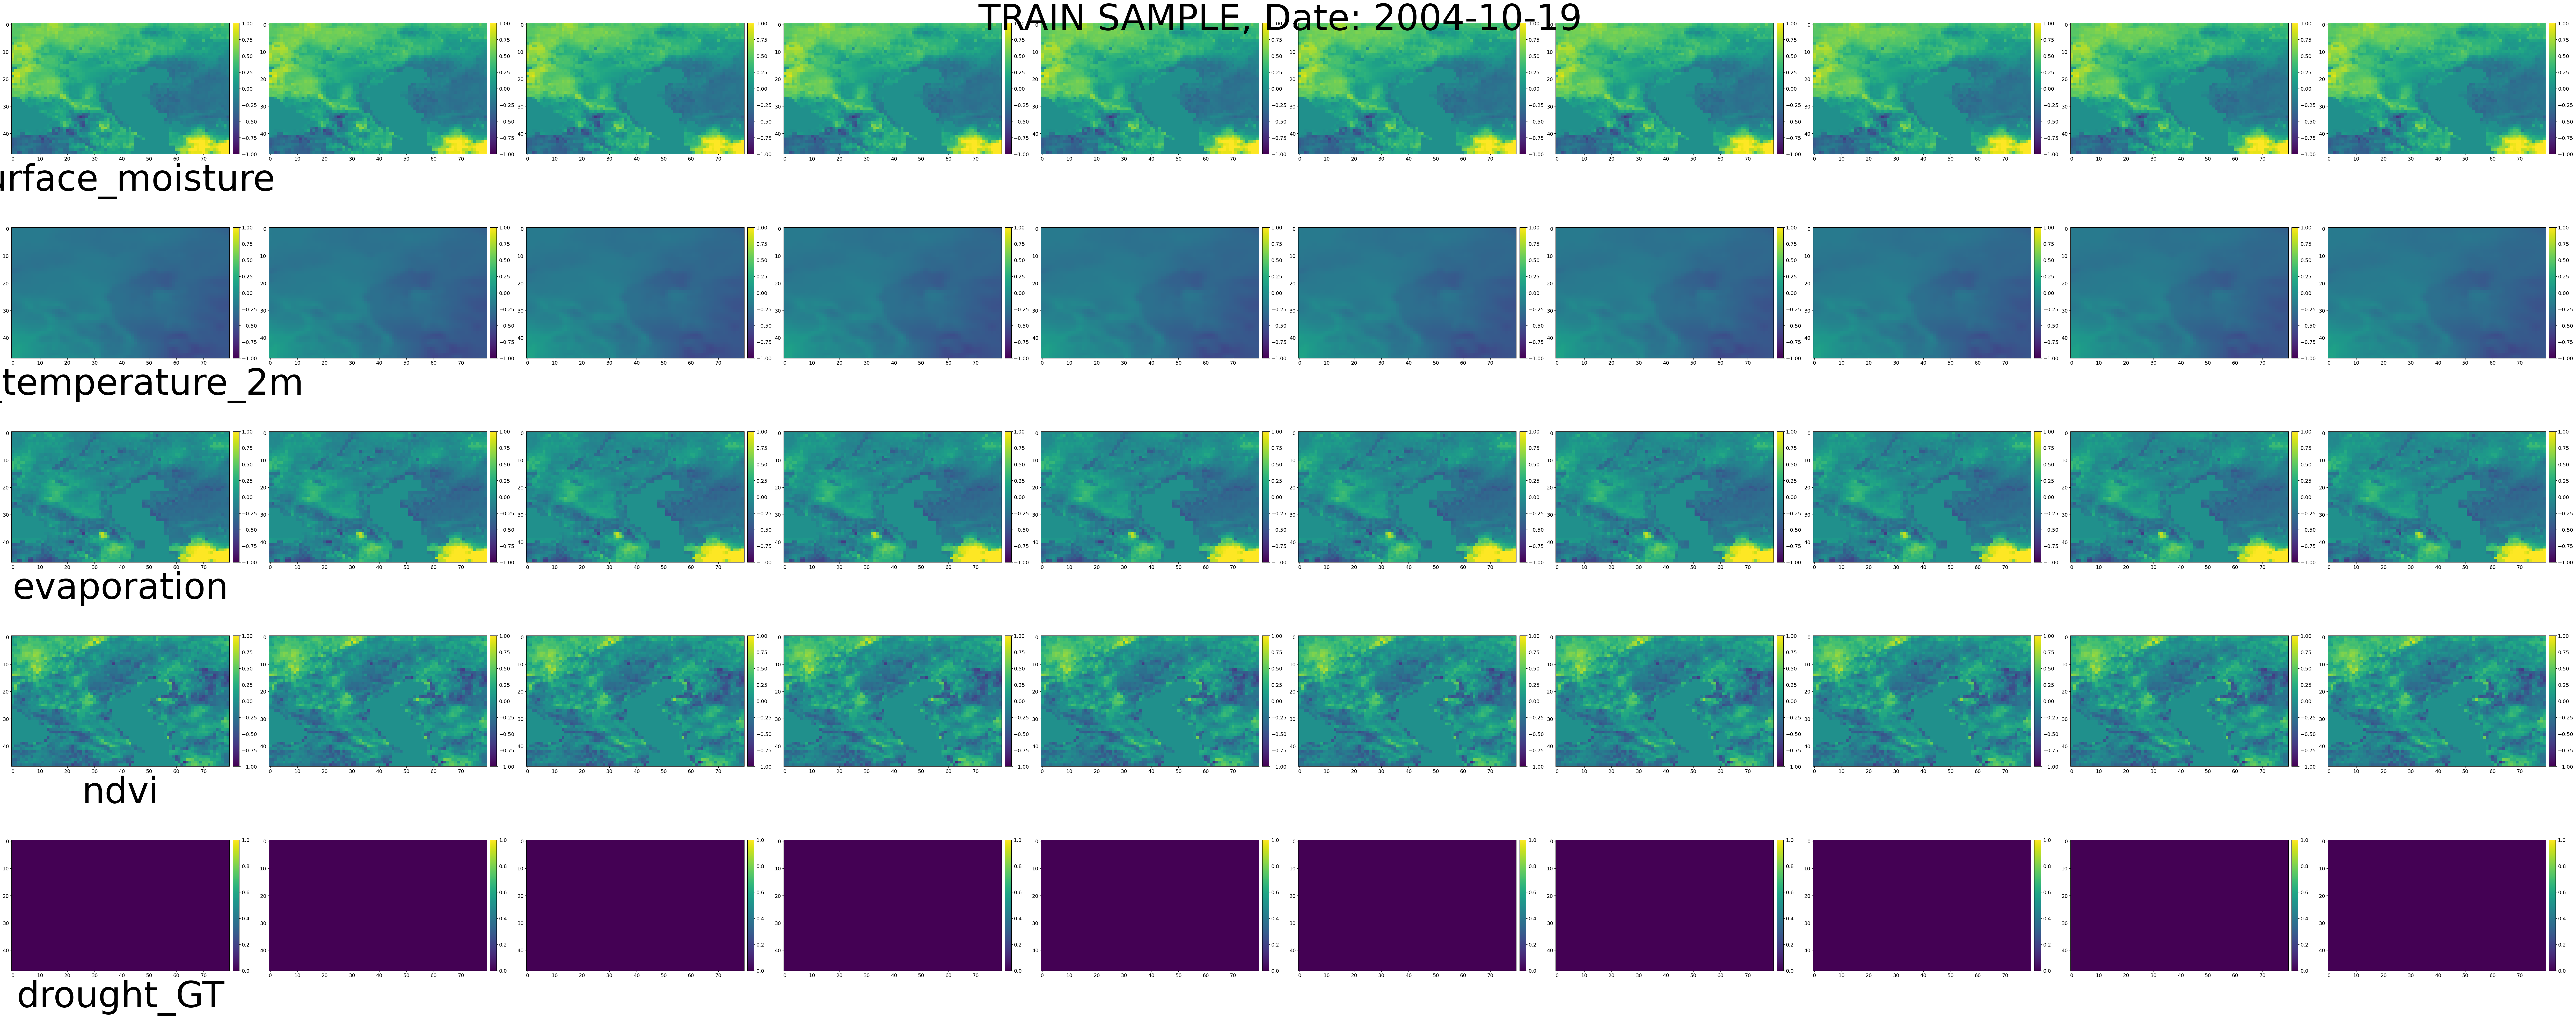

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

fig, axs = plt.subplots(5, 10, figsize=(100,40))
fig.tight_layout(pad=3)

x0_dict = data_train[0]
x0 = x0_dict["x"].numpy()
mask0 = x0_dict["masks"].numpy()
labels0 = x0_dict["labels"].numpy()
time0 = x0_dict["time"]
for i, idx in enumerate(np.linspace(0, x0.shape[1]-1, 10, dtype=int)):
    im0 = axs[0][i].imshow(x0[0, idx], vmin = -1, vmax =1)
    if i==0: axs[0][i].set_xlabel("surface_moisture", fontsize=100)
    add_colorbar(im0, ax=axs[0][i])
    
    im1 = axs[1][i].imshow(x0[1, idx], vmin = -1, vmax =1)
    if i==0: axs[1][i].set_xlabel("air_temperature_2m", fontsize=100)
    add_colorbar(im1, ax=axs[1][i])
    
    im2 = axs[2][i].imshow(x0[2, idx], vmin = -1, vmax =1)
    if i==0: axs[2][i].set_xlabel("evaporation", fontsize=100)
    add_colorbar(im2, ax=axs[2][i])

    im3 = axs[3][i].imshow(x0[3, idx], vmin = -1, vmax =1)
    if i==0: axs[3][i].set_xlabel("ndvi", fontsize=100)
    add_colorbar(im3, ax=axs[3][i])
    
    im4 = axs[4][i].imshow(labels0[0, idx], vmin = 0, vmax =1)
    if i==0: axs[4][i].set_xlabel("drought_GT", fontsize=100)
    add_colorbar(im4, ax=axs[4][i])
    
    plt.suptitle("TRAIN SAMPLE, Date: " + str(time0), fontsize=100)

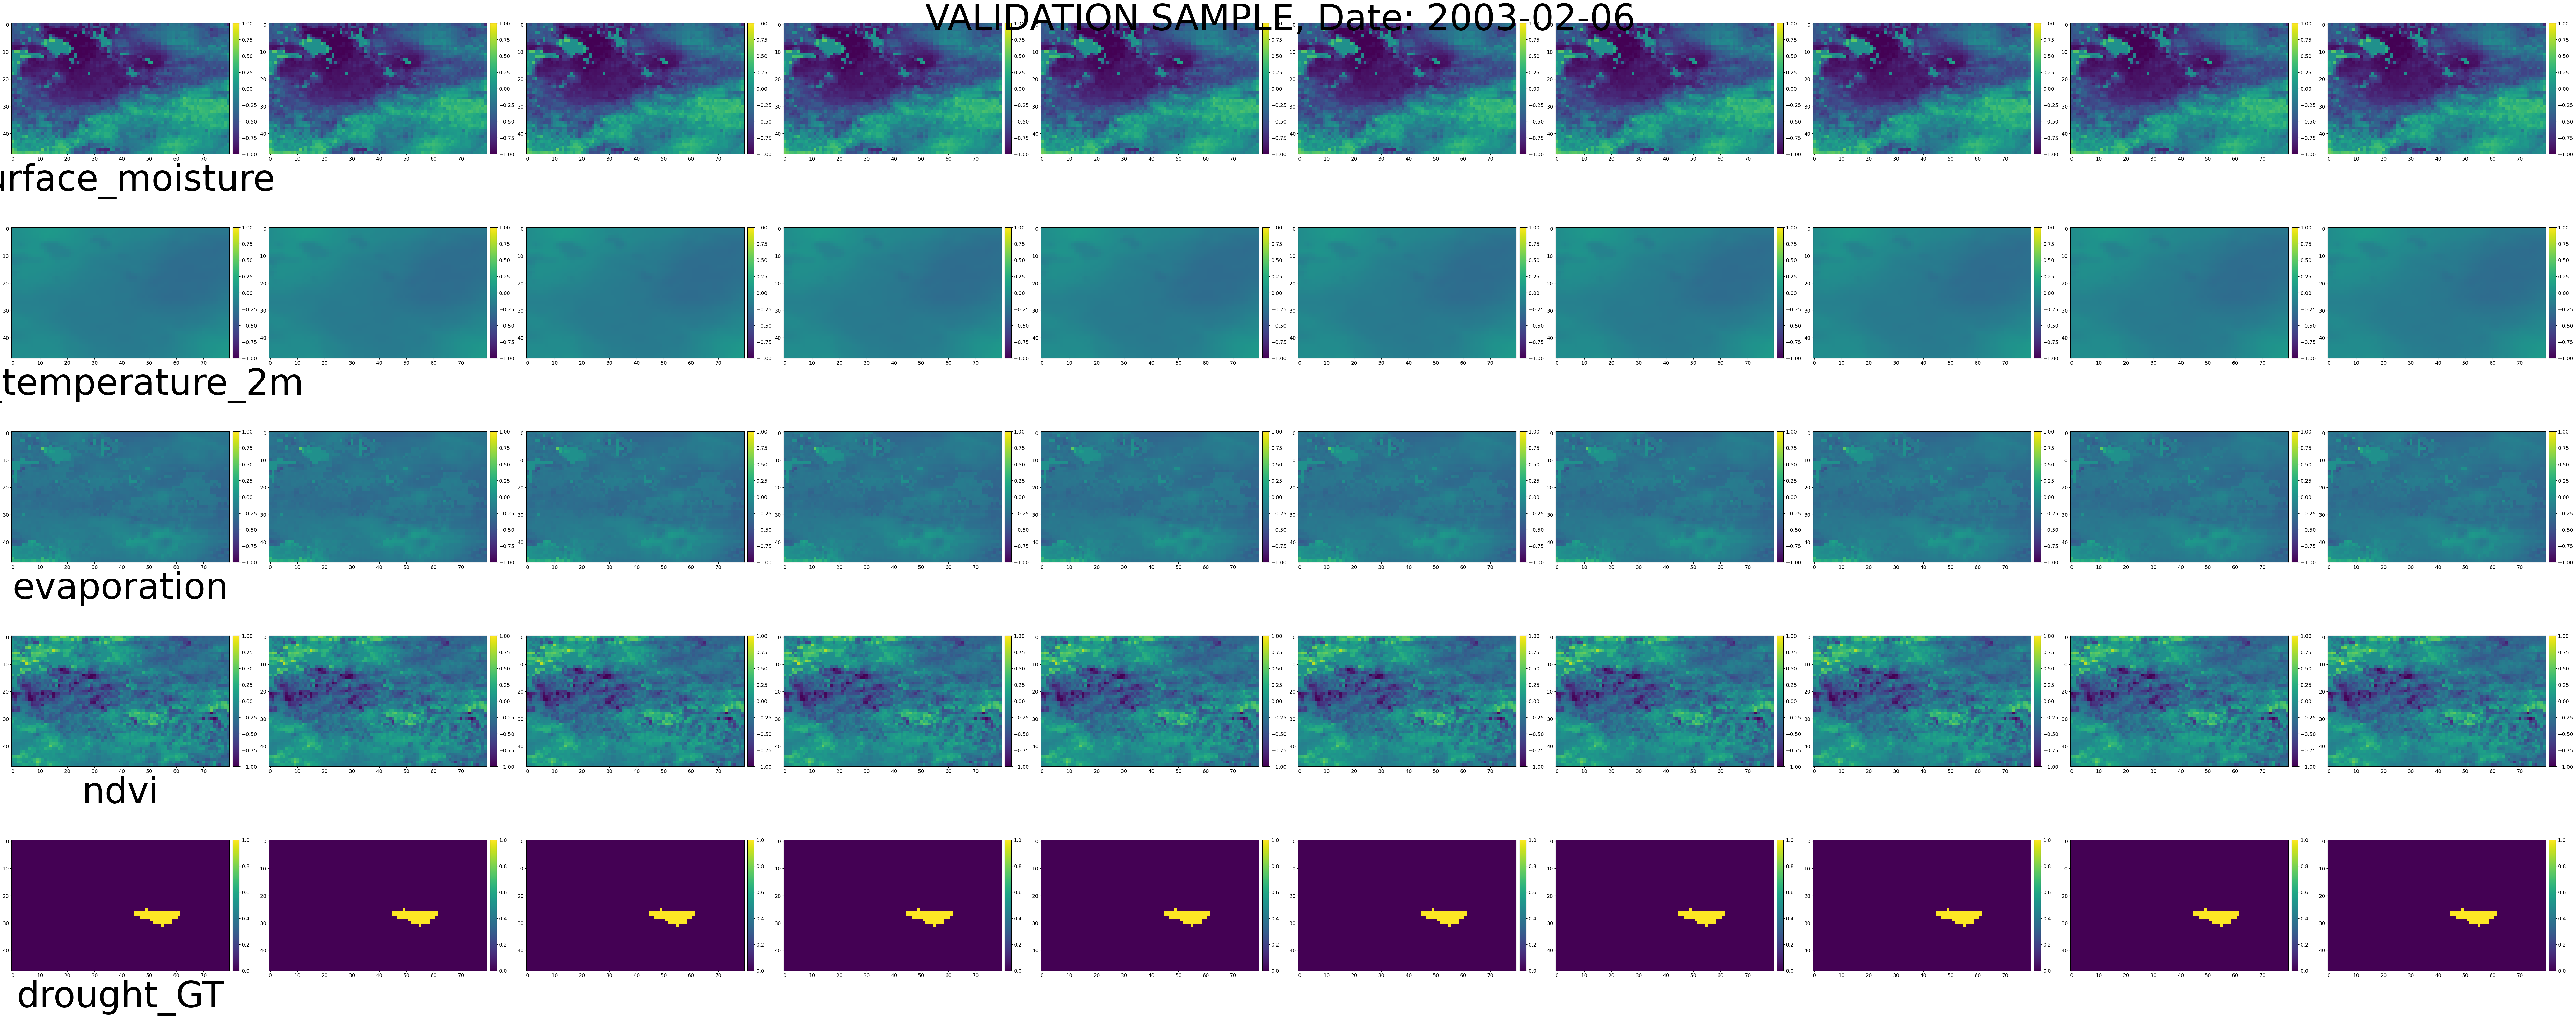

In [7]:
fig, axs = plt.subplots(5, 10, figsize=(100,40))
fig.tight_layout(pad=3)

x0_dict = data_val[4]
x0 = x0_dict["x"].numpy()
mask0 = x0_dict["masks"].numpy()
labels0 = x0_dict["labels"].numpy()
time0 = x0_dict["time"]
for i, idx in enumerate(np.linspace(0, x0.shape[1]-1, 10, dtype=int)):
    im0 = axs[0][i].imshow(x0[0, idx], vmin = -1, vmax =1)
    if i==0: axs[0][i].set_xlabel("surface_moisture", fontsize=100)
    add_colorbar(im0, ax=axs[0][i])
    
    im1 = axs[1][i].imshow(x0[1, idx], vmin = -1, vmax =1)
    if i==0: axs[1][i].set_xlabel("air_temperature_2m", fontsize=100)
    add_colorbar(im1, ax=axs[1][i])
    
    im2 = axs[2][i].imshow(x0[2, idx], vmin = -1, vmax =1)
    if i==0: axs[2][i].set_xlabel("evaporation", fontsize=100)
    add_colorbar(im2, ax=axs[2][i])

    im3 = axs[3][i].imshow(x0[3, idx], vmin = -1, vmax =1)
    if i==0: axs[3][i].set_xlabel("ndvi", fontsize=100)
    add_colorbar(im3, ax=axs[3][i])
    
    im4 = axs[4][i].imshow(labels0[0, idx], vmin = 0, vmax =1)
    if i==0: axs[4][i].set_xlabel("drought_GT", fontsize=100)
    add_colorbar(im4, ax=axs[4][i])

    plt.suptitle("VALIDATION SAMPLE, Date: " + str(time0), fontsize=100)

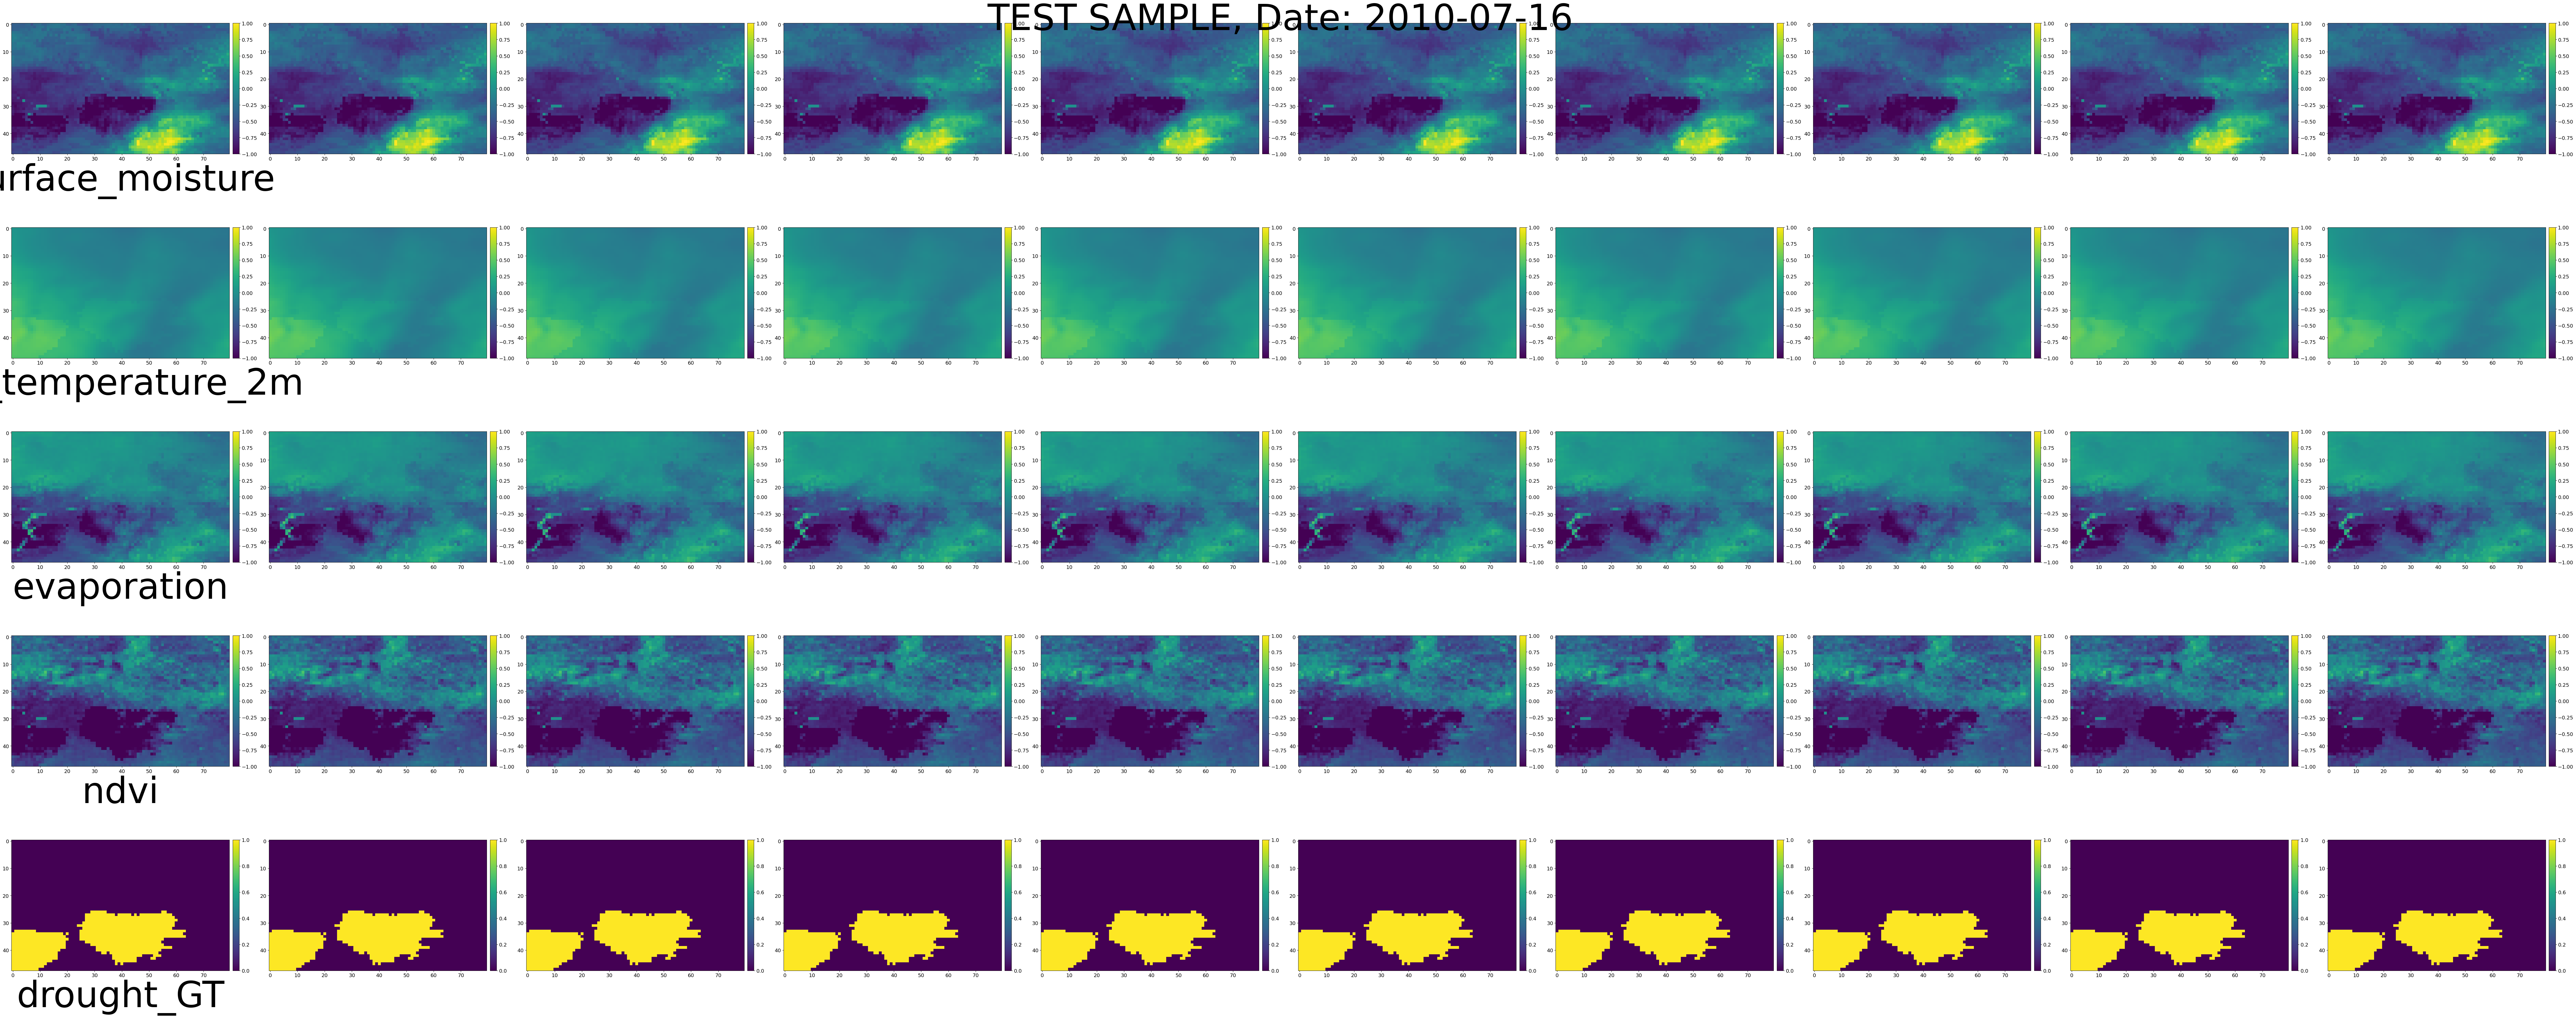

In [8]:
fig, axs = plt.subplots(5, 10, figsize=(100,40))
fig.tight_layout(pad=3)

x0_dict = data_test[70]
x0 = x0_dict["x"].numpy()
mask0 = x0_dict["masks"].numpy()
labels0 = x0_dict["labels"].numpy()
time0 = x0_dict["time"]
for i, idx in enumerate(np.linspace(0, x0.shape[1]-1, 10, dtype=int)):
    im0 = axs[0][i].imshow(x0[0, idx], vmin = -1, vmax =1)
    if i==0: axs[0][i].set_xlabel("surface_moisture", fontsize=100)
    add_colorbar(im0, ax=axs[0][i])
    
    im1 = axs[1][i].imshow(x0[1, idx], vmin = -1, vmax =1)
    if i==0: axs[1][i].set_xlabel("air_temperature_2m", fontsize=100)
    add_colorbar(im1, ax=axs[1][i])
    
    im2 = axs[2][i].imshow(x0[2, idx], vmin = -1, vmax =1)
    if i==0: axs[2][i].set_xlabel("evaporation", fontsize=100)
    add_colorbar(im2, ax=axs[2][i])

    im3 = axs[3][i].imshow(x0[3, idx], vmin = -1, vmax =1)
    if i==0: axs[3][i].set_xlabel("ndvi", fontsize=100)
    add_colorbar(im3, ax=axs[3][i])
    
    im4 = axs[4][i].imshow(labels0[0, idx], vmin = 0, vmax =1)
    if i==0: axs[4][i].set_xlabel("drought_GT", fontsize=100)
    add_colorbar(im4, ax=axs[4][i])

    plt.suptitle("TEST SAMPLE, Date: " + str(time0), fontsize=100)

---
## 3. MODEL (UNET) AND TRAINING STAGE
---
We at first initialize the defined model, then fit it on the training dataset.

---
### 3.1 MODEL INITIALIZATION AND SUMMARY
---
Here we define and initialize a UNET. Besides, we print a summary of the model, to review the configuration of its different submodules and layers.

In [9]:
#Create experimental folder structure if it was not already created
if not Path(config['save_path']).name == config['experiment_id'].replace('/', ''):
    save_path= Path(config['save_path']) / Path(config['experiment_id'])
    config['save_path']= str(save_path.resolve())
    save_path.mkdir(exist_ok=True, parents=True) 
else:
    save_path= Path(config['save_path'])
print(f'Logging experiment data at: {save_path}')

classifier = PytorchBackbone(config)
# Load data
classifier.load_data()
# Model
classifier.implement_model()
classifier.model

Logging experiment data at: experiments/DROUGHT_RUSSIA_SMP_LPS2025
Constructing DROUGHT train...
Constructing DROUGHT val...
Constructing DROUGHT test...


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


PytorchModel(
  (model): Unet(
    (encoder): MobileNetV2Encoder(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): C

---
### 3.2 TRAINING STAGE
--- 
DL models follow iterative processes to learn representations of the data. From the ML practitioner's perspective, this behavior usually needs to be controlled to avoid difficulties in the learning task (e.g. overfitting or retaining bad weights to be used in testing). With that in mind, the framework implements different classes under a PyTorch Lightning object called **callback**. Three callbacks are supplied in this version of the module: **ModelSummary**, **EarlyStopping**, and **ModelCheckpoint**. 

**ModelSummary** collects and prints a table with columns describing each layer of the model by means of its name, type, number of parameters, input, and output shapes. This is visible up to the layer defined by the hyperparameter max_depth (set to -1 to show all layers). 

**Early stopping** is a common and usually required, regularization technique to avoid overfitting the model to the training data. The functionality of its corresponding callback is simple: it stops training when the parameters learned for the model no longer improve the performance of the system over the validation data. 

Finally, when training neural networks, the learning step always fluctuates between better-fitted and worse-fitted models. When the model is learning faster, usually during the first epochs, the overall trend of these fluctuations points to better models. Nevertheless, at some point, the learning procedure can get stuck. As it might be the case after many epochs while training with very small learning steps or with high patience for the early stopping. For this reason, it is advisable to save more than one fitted model when performing experiments. More so when one encounters multiple maxima or minima in the function of the monitored metric. **ModelCheckpoint** is the callback responsible for this.

### Train 

We make use of TensorBoard to see how our model has learnt. The train_val_losses drop-down will show a graphic depicting the performance of our model during all training steps.

In [10]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

save_path= Path(config['save_path'])

tensorboard_path = save_path / 'lightning_logs'

%tensorboard --logdir="$tensorboard_path" --port=6010

In [11]:
"""
training the DL model
"""
model = classifier.train()

Missing logger folder: experiments/DROUGHT_RUSSIA_SMP_LPS2025/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

    | Name                                        | Type                 | Params
---------------------------------------------------------------------------------------
0   | model                                       | Unet                 | 2.2 M 
1   | model.encoder                               | MobileNetV2Encoder   | 2.2 M 
2   | model.encoder.features                      | Sequential           | 2.2 M 
3   | model.encoder.features.0                    | Conv2dNormActivation | 1.2 K 
4   | model.encoder.features.0.0                  | Conv2d               | 1.2 K 
5   | model.encoder.features.0.1                  | BatchNorm2d          | 64    
6   | model.encoder.features.0.2                  | ReLU6                | 0     
7   | model.encoder.features.1                    | InvertedResidual     | 896   
8   | model.encoder.features.1.conv               | Se

{'lr': 0.0001, 'weight_decay': 0}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Evaluating experiments/DROUGHT_RUSSIA_SMP_LPS2025/checkpoints/epoch=18-val_AUROC=0.710132.ckpt


---
## 4. EVALUATION AND VISUALIZATION OF RESULTS
---
The evaluation metrics are integrated inside the model execution pipeline. For the supervised deep learning architectures, the evaluation metrics are integrated with the provided automatic log functionalities by Pytorch Lightning.

The following metrics are available in the toolbox to evaluate the performance of the detection algorithms:
> - **Accuracy**: Provides the percentage of samples that have been correctly classified. It is recommended to complement this metric with other metrics when working with imbalanced datasets.
> - **Area Under the Curve (AUC)**: The AUC measures the ability of a model to distinguish between classes. The available models of this toolbox are used to predict the probability of a data point belonging to different classes. Thresholding is usually used to interpret the results of the model, with different thresholds providing different results. This metric is an aggregate measure of the algorithm’s performance for all the possible classification thresholds.
> - **Area Under the Precision-Recall Curve (AUC-PR) or Average Precision**: AP is a popular performance metric used to interpret binary classification models. It is computed as the area under the precision-recall curve for different probability thresholds, in a similar way as AUC. The main difference between AUC resides in the fact that the ROC curve covers both positive and negative classes. Whereas in the AP, by definition, the precision and the recall are focused on the positive class and are unconcerned with the true negatives. When working with an imbalanced dataset, where the positive class is the minority, the AUROC metric can prove over-optimistic while AP can be more informative of the model performance.
> - **F1-score**: Measure of predictive performance. It is calculated from the precision and recall of the test, where the precision is the number of true positive results divided by the number of all samples predicted to be positive, including those not identified correctly, and the recall is the number of true positive results divided by the number of all samples that should have been identified as positive. Precision is also known as positive predictive value, and recall is also known as sensitivity in diagnostic binary classification.

We evaluate the trained model and visualize its final predictions on the test dataset.

In [12]:
"""
evaluating the DL model
"""
classifier.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_AUROC         │    0.5888571739196777     │
│       test_Accuracy       │    0.7373411059379578     │
│   test_AveragePrecision   │    0.09246787428855896    │
│       test_F1Score        │    0.09337371587753296    │
│      test_loss_epoch      │   0.021316474303603172    │
└───────────────────────────┴───────────────────────────┘

---
## 5. VISUALIZATION, CHARACTERIZATION AND EXPLAINABILITY OF RESULTS
---
The toolbox provides visualization, characterization and explainability utilities that are activated and modifyied as per the user interest in the config file. These are called during the inference stage.

Infering Dataloader: 100%|████████████████████████████████| 183/183 [00:02<00:00, 78.09it/s]


experiments/DROUGHT_RUSSIA_SMP_LPS2025/spatial_visualization


Performing visualization: 100%|███████████████████████████| 183/183 [02:09<00:00,  1.41it/s]


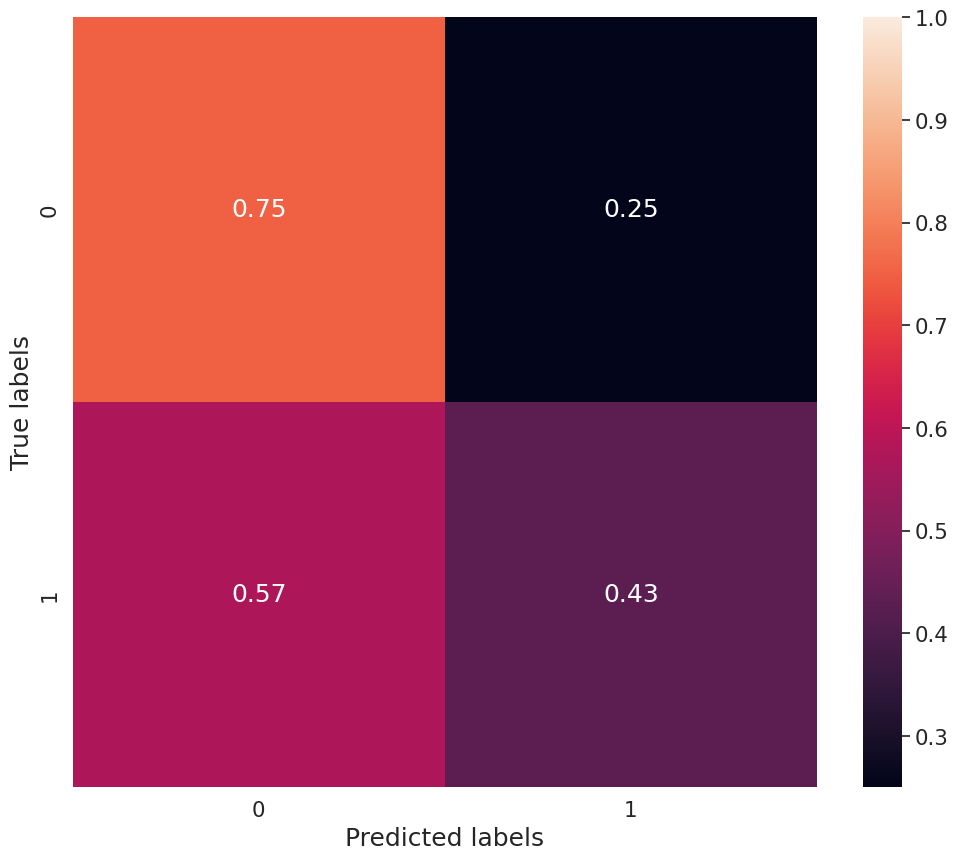

In [13]:
classifier.config['evaluation']['visualization']['activate']= True
classifier.config['evaluation']['characterization']['activate']= False
classifier.config['evaluation']['xai']['activate']= False
output_data = classifier.inference(subset='test')

In [14]:
classifier.config['evaluation']['visualization']['activate']= False
classifier.config['evaluation']['characterization']['activate']= True
classifier.config['evaluation']['xai']['activate']= False
attr_output = classifier.inference(subset='test')

Infering Dataloader: 100%|██████████████████████████████████| 92/92 [00:04<00:00, 21.75it/s]


Optimizing threshold
Starting characterization ...
Saved characterization results in folderexperiments/DROUGHT_RUSSIA_SMP_LPS2025/characterization_stats


Images and numerical results are stored in the experimental folder. For ilustration purposes, these are called in the next cells. In here, we show the detection curves, drought maps, characterization table, and the explainability figures.

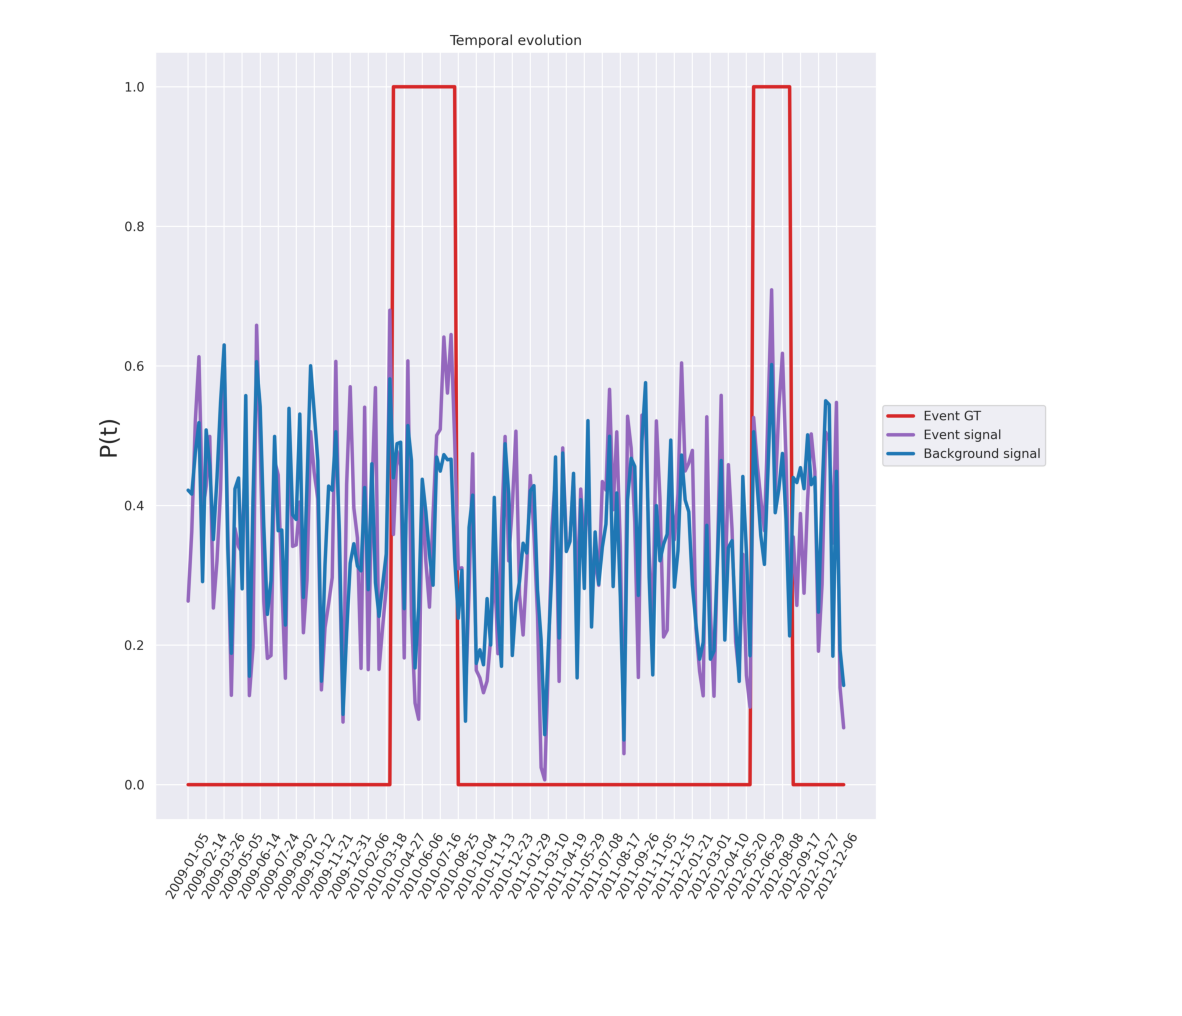

In [15]:
from PIL import Image
from pathlib import Path

# showing detection curves
path = Path(classifier.config['save_path']) / 'c1_temporalEvolution.png'
img= np.asarray(Image.open(path))
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.axis(False)
plt.show()
plt.close()

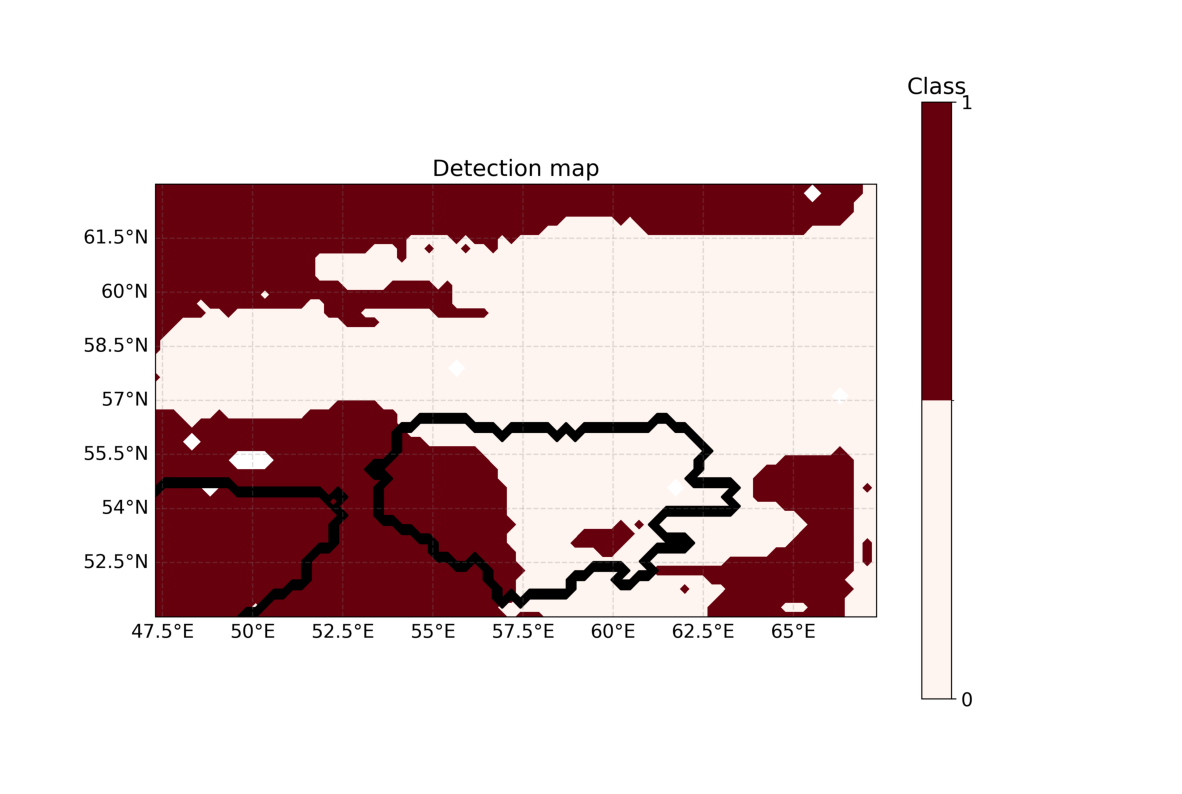

In [16]:
# showing drought maps
path = Path(classifier.config['save_path']) / 'spatial_visualization' / '2010-08-01_aggregation_spatialEvolution.png'
img= np.asarray(Image.open(path))
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.axis(False)
plt.show()
plt.close()

In [17]:
with open(classifier.config['save_path'] + '/characterization_stats/0.txt') as f:
    file_contents = f.read()
    print(file_contents)

                    Extent (samples)                                           Location (centroid)                                Location (weighted centroid)  Max prob  Mean prob  Min prob  Std prob
Class_1 Event_id_1               116    (71.60344827586206, 40.08620689655172, 19.120689655172413)  (71.60231321006873, 40.092121133294796, 19.10353191188783)  0.956755   0.935770  0.926406  0.007511
        Event_id_9               109  (162.52293577981652, 38.321100917431195, 55.477064220183486)  (162.5247427182079, 38.314200287081164, 55.50129077493814)  0.971241   0.936967  0.926297  0.009183


In [18]:
classifier.config['evaluation']['visualization']['activate']= False
classifier.config['evaluation']['characterization']['activate']= False 
classifier.config['evaluation']['xai']['activate']= True
xai_output = classifier.inference(subset='test')

Infering Dataloader: 100%|██████████████████████████████████| 92/92 [00:04<00:00, 20.77it/s]


Optimizing threshold


Visualizing explanations: 100%|███████████████████████████| 183/183 [01:20<00:00,  2.27it/s]


70


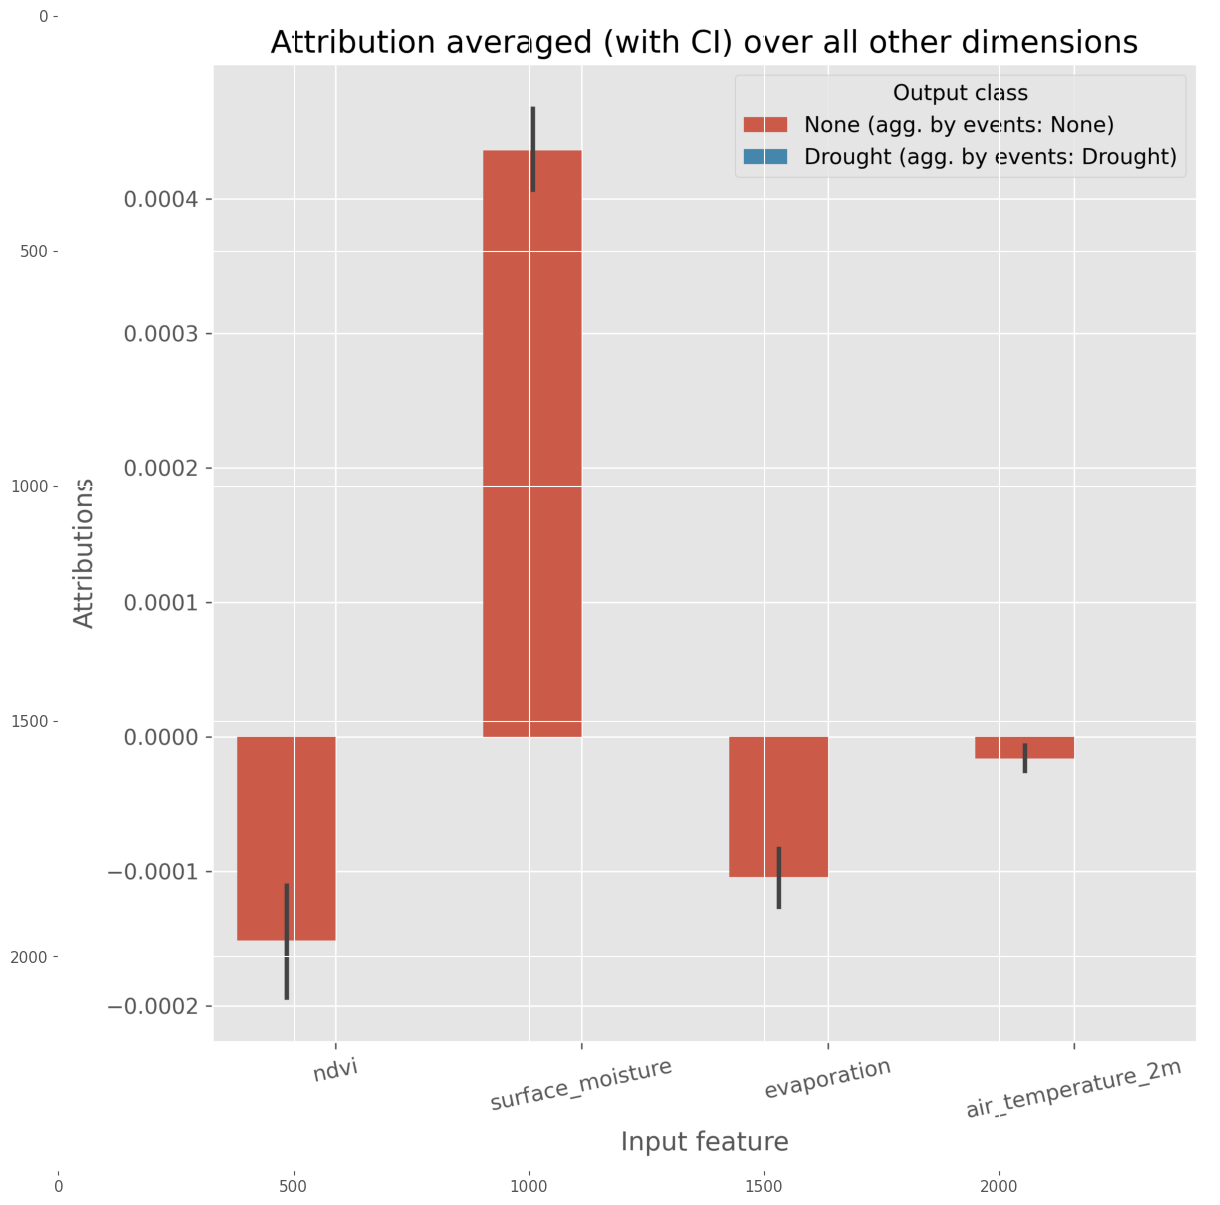

In [19]:
# explainability figures (Saliency) 
from PIL import Image
from pathlib import Path

event_name= output_data['event_names'][70]
print(event_name)
path= Path(classifier.config['save_path']) / 'xai' / f'{event_name}_agg-events_nd.png'
img= np.asarray(Image.open(path))
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show()
plt.axis(False);